In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import datetime
import warnings
warnings.filterwarnings('ignore')
from pandas.tseries.offsets import BusinessDay
from pandas.tseries.offsets import MonthEnd
import numpy as np
import zqdatac
import matplotlib.pyplot as plt

In [2]:
reps = [d.strftime('%Y%m%d') for d in pd.date_range(start='20100331',end='20221231',freq='3M')]
reps_semi = [d.strftime('%Y%m%d') for d in pd.date_range(start='20100630',end='20221231',freq='6M')]

In [3]:
calendar = zqdatac.MarketCalendar().dates

### 权益型基金

In [4]:
def newly_listed(df_descri,trade_dates,sl,day=365):
    df_descri = df_descri.sort_values(by='OPDATE')
    df_descri = df_descri.set_index(['F_INFO_WINDCODE'])
    df_descri = df_descri[~df_descri.index.duplicated(keep='last')]['F_INFO_SETUPDATE'].reset_index()
    df_descri = df_descri[df_descri.F_INFO_WINDCODE.isin(sl)]
    df_descri['VALID_DATE'] = ((pd.to_datetime(df_descri.F_INFO_SETUPDATE.astype(str))+pd.Timedelta(days=day)).dt.strftime('%Y%m%d')).astype(int)
    df_valid = df_descri[['F_INFO_WINDCODE', 'VALID_DATE']].set_index(['F_INFO_WINDCODE']).T
    df_dates = pd.DataFrame(index=trade_dates, data=df_valid.values.tolist() * len(trade_dates),
                                columns=df_valid.columns)
    df_valid = df_dates.sub(trade_dates,axis=0)<=0
    df_valid.index.name = None
    df_valid.columns.name = None
    return df_valid

In [5]:
def still_alive(df_descri,trade_dates,sl):
    df_descri['F_INFO_MATURITYDATE'] = df_descri.F_INFO_MATURITYDATE.fillna(datetime.datetime.now().strftime('%Y%m%d'))
    df_descri = df_descri.sort_values(by='OPDATE')
    df_descri = df_descri.set_index(['F_INFO_WINDCODE'])
    df_descri = df_descri[~df_descri.index.duplicated(keep='last')]['F_INFO_MATURITYDATE'].reset_index()
    df_descri = df_descri[df_descri.F_INFO_WINDCODE.isin(sl)]
    df_descri['VALID_DATE'] = (df_descri.F_INFO_MATURITYDATE).astype(int)
    df_valid = df_descri[['F_INFO_WINDCODE', 'VALID_DATE']].set_index(['F_INFO_WINDCODE']).T
    df_dates = pd.DataFrame(index=trade_dates, data=df_valid.values.tolist() * len(trade_dates),
                                columns=df_valid.columns)
    df_valid = df_dates.sub(trade_dates,axis=0)>=0
    df_valid.index.name = None
    df_valid.columns.name = None
    return df_valid

用年报和半年报的配置数据筛选 \
成立3年以上 \
不要ETF \
筛选行业主题的基金（基金股票仓位>50%, 指定行业是第一重仓行业，行业的持股权重大于300指数的行业持股权重）\
行业股持仓跑赢300指数的行业持仓

In [6]:
fund_descri = pq.read_table('data/ChinaMutualFundDescription.parquet.gz').to_pandas()
    ### A股权益类（股票&混合型基金），剔除（被动指数类基金、指数增强类基金、量化基金），剔除FOF，剔除QDII，若分级只保留A份额
    ### QDII中重仓A股的：110011.OF,002891.OF,005698.OF,006308.OF,001984.OF,005534.OF,003243.OF,012920.OF
fund_code_list = fund_descri[(fund_descri.F_INFO_FIRSTINVESTTYPE.isin(['股票型', '混合型'])) &
                             (fund_descri.IS_INDEXFUND == 0) &
                             (fund_descri.CRNY_CODE == 'CNY') &
                             (fund_descri.F_INFO_NAME.str.find('FOF') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('FOF') == -1) &
                             (fund_descri.F_INFO_NAME.str.find('QDII') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('QDII') == -1) &
                             (fund_descri.F_INFO_NAME.str.find('量化') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('量化') == -1) &
                             (fund_descri.F_INFO_ISINITIAL == 1) &
                             (fund_descri.F_INVESTMENT_AREA.isin(
                                 [None]))].F_INFO_WINDCODE.unique().tolist()
### 基金在报告期时成立时间大于半年
df_setup = newly_listed(fund_descri.dropna(subset=['F_INFO_SETUPDATE']), trade_dates=[int(d) for d in reps],
                        sl=fund_code_list, day=365 * 0.5)
### 基金在报告期时未到期
df_mature = still_alive(fund_descri, trade_dates=[int(d) for d in reps],
                        sl=df_setup.any(0)[df_setup.any(0)].index.tolist())
df_alive = (df_setup[df_setup.any(0)[df_setup.any(0)].index.tolist()]) & (df_mature)
df_alive = df_alive[df_alive.any(0)[df_alive.any(0)].index.tolist()]
df_alive.index = df_alive.index.astype(str)
del fund_descri

In [7]:
### 基金股票仓位占比在50%以上
fundasset = pq.read_table('data/ChinaMutualFundAssetPortfolio.parquet.gz').to_pandas()
fundasset = fundasset.set_index(['F_PRT_ENDDATE', 'S_INFO_WINDCODE'])
df_asset = fundasset.sort_values(by=['F_ANN_DATE', 'OPDATE'], ascending=[True, False])

df_stk = df_asset[~df_asset.index.duplicated(keep='first')]['F_PRT_STOCKTONAV']
df_stk = df_stk.unstack().reindex(reps)
# df_stk = df_stk.rolling(4, min_periods=2).mean()
df_stk = df_stk.reindex(df_alive.columns, axis='columns')[df_alive]
df_stk = df_stk >= 50

del fundasset

In [8]:
### 筛选结果求交集
df_avail = df_alive & df_stk
df_avail = df_avail[df_avail.any(0)[df_avail.any(0)].index.tolist()]

### 权益基金主管经理

In [9]:
# df_manager = pq.read_table('E:/doing/公募基金持仓/data/ChinaMutualFundManager.parquet.gz').to_pandas()

In [10]:
# df_manager = df_manager[df_manager.F_INFO_WINDCODE.isin(fund_code_list)]

In [11]:
# df_manager = df_manager.merge(df_manager[~df_manager.F_INFO_MANAGER_STARTDATE.isna()].groupby(['F_INFO_FUNDMANAGER_ID']).F_INFO_MANAGER_STARTDATE.min().astype(int).to_frame('TENURE'),
#                  how='left',left_on='F_INFO_FUNDMANAGER_ID',right_index=True)

In [12]:
# calendar = zqdatac.MarketCalendar().dates

In [13]:
# manger_records = []

In [14]:
# df_manager['F_INFO_MANAGER_LEAVEDATE'] = df_manager.F_INFO_MANAGER_LEAVEDATE.fillna('20230201')

In [15]:
# for i,row in df_manager.iterrows():
#     if row.F_INFO_MANAGER_STARTDATE is None:
#         continue
#     start = int(row.F_INFO_MANAGER_STARTDATE)
#     end = int(row.F_INFO_MANAGER_LEAVEDATE)
#     fund = row.F_INFO_WINDCODE               
#     df = pd.DataFrame(index=calendar.loc[start:end].index,columns=[fund],data=[row.F_INFO_FUNDMANAGER_ID]*len(calendar.loc[start:end]))
#     manger_records.append(df)

In [16]:
# len(manger_records)

In [17]:
# df_main_manager = pd.concat(manger_records,axis=1)

In [18]:
# df_main_manager = df_main_manager.stack().to_frame('FUNDMANAGER_ID')

In [19]:
# df_main_manager.index.names = ['TRADE_DT','FUNDCODE']

In [20]:
# df_main_manager = df_main_manager.reset_index()

In [21]:
# df_main_manager = df_main_manager.merge(df_manager[~df_manager.F_INFO_MANAGER_STARTDATE.isna()].groupby(['F_INFO_FUNDMANAGER_ID']).F_INFO_MANAGER_STARTDATE.min().astype(int).to_frame('TENURE'),
#                      how='left',left_on=['FUNDMANAGER_ID'],right_index=True)

In [22]:
# df_main_manager = df_main_manager.sort_values(by=['FUNDCODE','TRADE_DT','TENURE'])

In [23]:
# df_main_manager = df_main_manager.drop_duplicates(subset=['FUNDCODE','TRADE_DT'],keep='first')

In [24]:
# mat_main_manager = df_main_manager.set_index(['TRADE_DT','FUNDCODE'])['FUNDMANAGER_ID'].unstack()

In [25]:
# position_list =[]

In [26]:
# for fund,col in mat_main_manager.items():
#     col = col.loc[col.isna().idxmin():col[::-1].isna().idxmin()]
#     col = col.fillna(method='bfill')
#     position = col.where(col.isna(),1).astype(int).groupby((col != col.shift()).cumsum()).cumsum()
#     position_list.append(position)

In [27]:
# manager_position = pd.concat(position_list,axis=1)

In [28]:
# mat_main_manager.to_pickle('main_manager.pkl')

In [29]:
mat_main_manager = pd.read_pickle('main_manager.pkl')

### 行业主题型基金经理

In [30]:
### 筛选中报和年报的全持仓数据
holding = pq.read_table('data/ChinaMutualFundStockPortfolio.parquet.gz').to_pandas()
holding = holding[holding.F_PRT_ENDDATE.str[-4:].isin(['0630','1231'])]

In [31]:
### 基金筛选结果作用于持仓数据
holding = holding[
    (holding.S_INFO_WINDCODE.isin(df_avail.columns.tolist())) & (holding.F_PRT_ENDDATE.isin(reps_semi))]
holding = holding.set_index(['S_INFO_WINDCODE', 'F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE'])
holding = holding.sort_values(by=['F_PRT_ENDDATE', 'OPDATE'], ascending=[True, False])
holding = holding[~holding.index.duplicated(keep='first')]
holding = holding.reset_index()

In [32]:
mat_ind = zqdatac.industryCitics(level=1)
mat_ind = mat_ind.fillna(0).reindex(zqdatac.MarketCalendar().dates.loc[20100101:20221231].index).fillna(
    method='ffill').pipe(lambda x: x.mask(x == 0))
mat_ind.index = mat_ind.index.astype(str)

In [33]:
ind_mapping = {1: 'CI005001.WI',
 2: 'CI005002.WI',
 3: 'CI005003.WI',
 4: 'CI005004.WI',
 5: 'CI005005.WI',
 6: 'CI005006.WI',
 7: 'CI005007.WI',
 8: 'CI005008.WI',
 9: 'CI005009.WI',
 10: 'CI005010.WI',
 11: 'CI005011.WI',
 12: 'CI005012.WI',
 13: 'CI005013.WI',
 14: 'CI005014.WI',
 15: 'CI005015.WI',
 16: 'CI005016.WI',
 17: 'CI005017.WI',
 18: 'CI005018.WI',
 19: 'CI005019.WI',
 20: 'CI005020.WI',
 21: 'CI005021.WI',
 22: 'CI005022.WI',
 23: 'CI005023.WI',
 24: 'CI005030.WI',
 25: 'CI005024.WI',
 26: 'CI005025.WI',
 27: 'CI005026.WI',
 28: 'CI005027.WI',
 29: 'CI005028.WI',
 30: 'CI005029.WI'}

计算全市场所有基金经理在不同行业的持仓，以此作为比较基准。若某个基金经理在行业超配比例上超过 30%，则认为该基金是在该行业上的主题基金。

In [34]:
df_ind = mat_ind.reindex(reps_semi).stack().to_frame('IndustryCitics')
df_ind.index.names = ['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE']

In [35]:
mat_main_manager.index = mat_main_manager.index.astype(str)

In [36]:
mat_main_manager = mat_main_manager.reindex(reps_semi)

In [37]:
mat_main_manager = mat_main_manager.stack().to_frame('F_MANAGER')

In [38]:
mat_main_manager.index.names = ['F_PRT_ENDDATE','S_INFO_WINDCODE']

In [39]:
mat_main_manager = mat_main_manager.reset_index()

In [40]:
manager_holding = holding.merge(mat_main_manager,how='left',on=['S_INFO_WINDCODE','F_PRT_ENDDATE'])

In [41]:
manager_holding_ind = manager_holding.merge(df_ind.reset_index(), how='left', on=['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE'])

In [42]:
manager_holding_ind = manager_holding_ind[['F_MANAGER','S_INFO_WINDCODE','F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_PRT_STKVALUETONAV','IndustryCitics']]

#### ind max1

In [43]:
# manager_holding_avg = manager_holding.groupby(['F_MANAGER','F_PRT_ENDDATE','S_INFO_STOCKWINDCODE']).F_PRT_STKVALUETONAV.max()

In [44]:
# manager_holding_avg = manager_holding_avg.reset_index()

In [45]:
# manager_holding_ind = manager_holding_avg.merge(df_ind.reset_index(), how='left', on=['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE'])

In [46]:
# manager_holding_ind_weight = manager_holding_ind.groupby(['F_MANAGER','F_PRT_ENDDATE','IndustryCitics']).F_PRT_STKVALUETONAV.sum()

#### ind max2

In [47]:
holding_ind = manager_holding_ind.groupby(['F_PRT_ENDDATE','S_INFO_WINDCODE','IndustryCitics']).F_PRT_STKVALUETONAV.sum().reset_index()

In [48]:
manager_holding_ind_weight = holding_ind.merge(mat_main_manager,how='left',on=['F_PRT_ENDDATE','S_INFO_WINDCODE'])

In [49]:
manager_holding_ind_weight = manager_holding_ind_weight.groupby(['F_MANAGER','F_PRT_ENDDATE','IndustryCitics']).F_PRT_STKVALUETONAV.max()

In [50]:
manager_holding_ind_weight = ((manager_holding_ind_weight.to_frame('Ind_Weight')).reset_index()).merge(manager_holding_ind_weight.swaplevel().unstack().unstack().mean().to_frame('Ind_Weight_avg').reset_index(),
                                                            how='left',on=['F_PRT_ENDDATE','IndustryCitics'])

In [51]:
manager_holding_ind_weight['Ind_Weight_rank'] = manager_holding_ind_weight.groupby(['F_PRT_ENDDATE','IndustryCitics']).Ind_Weight.rank(method='min',ascending=False)

In [52]:
# ind_manager = manager_holding_ind_weight[manager_holding_ind_weight.Ind_Weight_rank<=10]

In [53]:
# ind_manager = manager_holding_ind_weight[manager_holding_ind_weight.Ind_Weight-manager_holding_ind_weight.Ind_Weight_avg>=20]

In [54]:
ind_manager = manager_holding_ind_weight[(manager_holding_ind_weight.Ind_Weight-manager_holding_ind_weight.Ind_Weight_avg>=20)\
                                         | (manager_holding_ind_weight.Ind_Weight_rank<=10)]

In [55]:
ind_manager = ind_manager.rename(columns={'F_MANAGER':'F_INFO_FUNDMANAGER_ID'})

In [56]:
manager_names = pq.read_table('E:/doing/公募基金持仓/data/ChinaMutualFundManager.parquet.gz').to_pandas().set_index(['F_INFO_FUNDMANAGER_ID'])['F_INFO_FUNDMANAGER'].dropna().reset_index().drop_duplicates()

In [57]:
ind_manager = ind_manager.merge(manager_names,how='left',on=['F_INFO_FUNDMANAGER_ID'])

In [58]:
ind_manager

,F_INFO_FUNDMANAGER_ID,F_PRT_ENDDATE,IndustryCitics,Ind_Weight,Ind_Weight_avg,Ind_Weight_rank,F_INFO_FUNDMANAGER
0,00001,20121231,12.0,4.67,1.778346,10.0,白仲光
1,00001,20130630,10.0,15.32,3.535438,1.0,白仲光
2,00001,20130630,17.0,6.68,1.652532,5.0,白仲光
3,00001,20131231,19.0,24.41,6.765789,6.0,白仲光
4,00001,20140630,3.0,16.80,2.653464,4.0,白仲光
...,...,...,...,...,...,...,...
10643,JR1518391,20220630,18.0,82.00,12.402223,45.0,池陈森
10644,JR1518391,20221231,18.0,41.81,12.814019,66.0,池陈森
10645,JR1518A35,20211231,3.0,27.96,4.514180,20.0,徐志华
10646,JR1518A35,20220630,3.0,32.08,5.353505,18.0,徐志华


In [59]:
# ind_manager.to_pickle('ind_manager.pkl')

In [60]:
# ind_manager = pd.read_pickle('ind_manager.pkl')

### 季报重仓（前十大）

In [61]:
stocks = pq.read_table('data/ChinaMutualFundStockPortfolio.parquet.gz').to_pandas()

In [62]:
stocks = stocks[stocks.F_PRT_ENDDATE.str[-4:].isin(['0331','0930','0630','1231'])]

In [63]:
stocks['ANN_DEADLINE'] = pd.to_datetime(stocks['F_PRT_ENDDATE']) + BusinessDay(20)
stocks = stocks[(stocks['ANN_DEADLINE'] - pd.to_datetime(stocks['ANN_DATE'])).dt.days >= 0]

In [64]:
stocks = stocks[(stocks.S_INFO_WINDCODE.isin(fund_code_list))&(stocks.F_PRT_ENDDATE.isin(reps))]

In [65]:
stocks['STK_HLD_RANK'] = stocks.groupby(['S_INFO_WINDCODE', 'F_PRT_ENDDATE']).F_PRT_STKVALUETONAV.apply(
        lambda x: x.rank(method='min', ascending=False))

In [66]:
top10_stocks = stocks[stocks.STK_HLD_RANK <= 10]

In [67]:
top10_stocks = top10_stocks[(top10_stocks.S_INFO_STOCKWINDCODE.str[0].isin(['0', '3', '6'])) & (top10_stocks.S_INFO_STOCKWINDCODE.str[-3:].isin(['.SZ', '.SH']))]

In [68]:
df_ind = mat_ind.reindex(reps).stack().to_frame('IndustryCitics')
df_ind.index.names = ['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE']

In [69]:
top10_stocks = top10_stocks[['S_INFO_WINDCODE','F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_PRT_STKVALUETONAV','STOCK_PER','FLOAT_SHR_PER']].merge(df_ind,how='left',on=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE'])

In [70]:
top10_stocks['F_PRT_ENDDATE'] = top10_stocks.F_PRT_ENDDATE.apply(lambda x:dict(zip(reps,reps[1:]+['20230331']))[x])

In [71]:
stk_list = top10_stocks.S_INFO_STOCKWINDCODE.unique().tolist()

In [72]:
# df_prices = zqdatac.stock_daily_price(startDate=20091231,endDate=20221231)

In [73]:
# df_prices['S_DQ_ADJCLOSE'].fillna(method='ffill').to_pickle('mat_close.pkl')

In [74]:
# mat_close.index = mat_close.index.astype(int)

In [75]:
mat_close = pd.read_pickle('mat_close.pkl')

In [76]:
dts = [str(d) for d in [20091231]+[int(d) for d in reps]]

In [77]:
dt_delay = lambda x: pd.Timestamp(x) + MonthEnd(0)

In [78]:
dts = [int(dt_delay(d).strftime('%Y%m%d')) for d in dts]

In [79]:
mat_close = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist())

In [80]:
mat_close.index = ['20091231'] + reps

In [81]:
df_ret = mat_close.reindex(columns=stk_list).pct_change(fill_method=None).iloc[1:]

In [82]:
df_ret = df_ret.stack().to_frame('Ret')

In [83]:
df_ret.index.names = ['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE']

In [84]:
top10_stocks = (top10_stocks).merge(df_ret.reset_index(),how='left',on=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE'])

In [85]:
# df_index = pq.read_table('data/AIndexWindIndustriesEOD.parquet.gz').to_pandas()

In [86]:
# df_index = df_index.sort_values(by=['S_INFO_WINDCODE','TRADE_DT','OPDATE','OPMODE']).drop_duplicates(subset=['S_INFO_WINDCODE','TRADE_DT'],keep='last')

In [87]:
# ind_close = df_index.set_index(['TRADE_DT','S_INFO_WINDCODE'])['S_DQ_CLOSE'].unstack().fillna(method='ffill')

In [88]:
# ind_close.index = ind_close.index.astype(int)

In [89]:
# ind_close.to_pickle('ind_close.pkl')

In [90]:
ind_close = pd.read_pickle('ind_close.pkl')

In [91]:
ind_close = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist())

In [92]:
ind_close.index = ['20091231']+reps
ind_close.index.names = ['F_PRT_ENDDATE']

In [93]:
ind_ret = ind_close.pct_change(fill_method=None).iloc[1:]

In [95]:
ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])

In [96]:
ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})

In [97]:
top10_stocks = top10_stocks.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])

In [98]:
top10_stocks['F_PRT_ENDDATE'] = top10_stocks.F_PRT_ENDDATE.astype(int)

In [99]:
mat_main_manager = pd.read_pickle('main_manager.pkl')

In [100]:
top10_stocks = top10_stocks.merge(mat_main_manager.reindex([int(rep) for rep in reps]).stack().to_frame('F_INFO_FUNDMANAGER_ID'),how='left',left_on=['F_PRT_ENDDATE','S_INFO_WINDCODE'],right_on=['TRADE_DT','FUNDCODE'])

In [101]:
top10_stocks['Alpha'] = top10_stocks.Ret - top10_stocks.Ind_Ret

### 不考虑仓位的重仓业绩

In [102]:
stocks_eval = top10_stocks.drop_duplicates(subset=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_INFO_FUNDMANAGER_ID'],keep='last')

In [103]:
stocks_eval['F_PRT_ENDDATE'] = stocks_eval.F_PRT_ENDDATE.astype(str)

In [104]:
stocks_eval = stocks_eval.groupby(['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID','IndustryCitics']).Alpha.mean()

In [105]:
stocks_eval = stocks_eval.reset_index()

In [106]:
# stocks_eval = stocks_eval.set_index(['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID','IndustryCitics']).Alpha.unstack().unstack().rolling(4,min_periods=1).mean().stack().stack().to_frame('Alpha').reset_index()

### 根据季度重仓股表现选择年报/半年报基金经理的全持仓

In [107]:
portf_list = []
for ind,sub in ind_manager.groupby('IndustryCitics'):
    if len(sub) < 10:
        continue
    print(ind,len(sub))
    sub = sub.merge(stocks_eval[stocks_eval.IndustryCitics==ind],how='left',on=['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])
    hld = manager_holding_ind[manager_holding_ind.IndustryCitics==ind]
    hld = hld.groupby(['F_PRT_ENDDATE','F_MANAGER'])['S_INFO_STOCKWINDCODE'].apply(list).to_frame()
    portf = sub.merge(hld,how='left',left_on=['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID'],right_index=True)
    portf = portf[portf.Alpha>0]
    portf = portf.set_index(['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])['S_INFO_STOCKWINDCODE'].explode()
    portf_list.append(portf)

1.0 260
2.0 267
3.0 329
4.0 260
5.0 260
6.0 284
7.0 260
8.0 260
9.0 260
10.0 265
11.0 604
12.0 405
13.0 268
14.0 260
15.0 260
16.0 260
17.0 261
18.0 1166
19.0 906
20.0 287
21.0 368
22.0 294
23.0 279
24.0 63
25.0 260
26.0 748
27.0 260
28.0 469
29.0 264
30.0 261


In [174]:
portf = pd.concat(portf_list,axis=0)

In [175]:
portf = portf.reset_index(level='F_INFO_FUNDMANAGER_ID',drop=True)

In [176]:
portf = portf.to_frame('STOCK_CODE')

In [177]:
portf['num'] = 1

In [178]:
portf = portf.set_index(['STOCK_CODE'],append=True)

In [179]:
portf['total'] = portf.groupby(['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE']).num.sum()

In [180]:
# False：将所有重复的项都标记为True（不管是不是第一次出现）
# df_portf = df_portf[~df_portf.index.duplicated(keep=False)]

In [181]:
df_portf = portf.reset_index()

In [182]:
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

In [183]:
def portf_stages(df_portf,mat_close,ind_close):
    # 中报/年报公布后的最近一个季报发布：0630->0731;1231->0131
    dts = [str(d) for d in [20091231]+[int(d) for d in reps_semi]]
    dt_delay1 = lambda x: pd.Timestamp(x) + MonthEnd(0) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(0)
    dt_delay2 = lambda x: pd.Timestamp(x) + MonthEnd(1) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(1)
    dts1 = [int(dt_delay1(d).strftime('%Y%m%d')) for d in dts]
    dts2 = [int(dt_delay2(d).strftime('%Y%m%d')) for d in dts]
    fut_ret1 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts1+dts2].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret1.index = ['20091231']+[d for d in reps_semi]
    fut_ret1.index.names = ['F_PRT_ENDDATE']
    fut_ret1 = fut_ret1.stack().to_frame('FUT_RET1')
    ind_ret1 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts1+dts2].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret1.index = ['20091231']+[d for d in reps_semi]
    ind_ret1.index.names = ['F_PRT_ENDDATE']
    ind_ret1 = ind_ret1.stack().to_frame('IND_FUT_RET1')
    # 最近一个季报发布到中报/年报发布：0731->0831;0131->0331
    dt_delay3 = lambda x: pd.Timestamp(x) + MonthEnd(3) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(2)
    dts3 = [int(dt_delay3(d).strftime('%Y%m%d')) for d in dts]
    fut_ret2 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts2+dts3].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret2.index = ['20091231']+[d for d in reps_semi]
    fut_ret2.index.names = ['F_PRT_ENDDATE']
    fut_ret2 = fut_ret2.stack().to_frame('FUT_RET2')
    ind_ret2 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts2+dts3].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret2.index = ['20091231']+[d for d in reps_semi]
    ind_ret2.index.names = ['F_PRT_ENDDATE']
    ind_ret2 = ind_ret2.stack().to_frame('IND_FUT_RET2')
    # 中报/年报发布到下一个季报发布：0831->1031;0331->0430
    dt_delay4 = lambda x: pd.Timestamp(x) + MonthEnd(4) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(4)
    dts4 = [int(dt_delay4(d).strftime('%Y%m%d')) for d in dts]
    fut_ret3 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts3+dts4].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret3.index = ['20091231']+[d for d in reps_semi]
    fut_ret3.index.names = ['F_PRT_ENDDATE']
    fut_ret3 = fut_ret3.stack().to_frame('FUT_RET3')
    ind_ret3 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts3+dts4].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret3.index = ['20091231']+[d for d in reps_semi]
    ind_ret3.index.names = ['F_PRT_ENDDATE']
    ind_ret3 = ind_ret3.stack().to_frame('IND_FUT_RET3')
    # 下一个季报发布到下下一个季报发布：1031->0131;0430->0731
    dt_delay5 = lambda x: pd.Timestamp(x) + MonthEnd(7) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(7)
    dts5 = [int(dt_delay5(d).strftime('%Y%m%d')) for d in dts]
    fut_ret4 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts4+dts5].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret4.index = ['20091231']+[d for d in reps_semi]
    fut_ret4.index.names = ['F_PRT_ENDDATE']
    fut_ret4 = fut_ret4.stack().to_frame('FUT_RET4')
    ind_ret4 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts4+dts5].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret4.index = ['20091231']+[d for d in reps_semi]
    ind_ret4.index.names = ['F_PRT_ENDDATE']
    ind_ret4 = ind_ret4.stack().to_frame('IND_FUT_RET4')
    # 下下一个季报发布到下一个年报/中报发布：0131->0331;0731->0831
    dt_delay6 = lambda x: pd.Timestamp(x) + MonthEnd(8) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(9)
    dts6 = [int(dt_delay6(d).strftime('%Y%m%d')) for d in dts]
    fut_ret5 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts5+dts6].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret5.index = ['20091231']+[d for d in reps_semi]
    fut_ret5.index.names = ['F_PRT_ENDDATE']
    fut_ret5 = fut_ret5.stack().to_frame('FUT_RET5')
    ind_ret5 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts5+dts6].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret5.index = ['20091231']+[d for d in reps_semi]
    ind_ret5.index.names = ['F_PRT_ENDDATE']
    ind_ret5 = ind_ret5.stack().to_frame('IND_FUT_RET5')
    
    fut_ret = pd.concat([fut_ret1,fut_ret2,fut_ret3,fut_ret4,fut_ret5],axis=1)
    ind_ret = pd.concat([ind_ret1,ind_ret2,ind_ret3,ind_ret4,ind_ret5],axis=1)
    fut_ret = fut_ret.reset_index()
    ind_ret = ind_ret.reset_index()
    ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])
    ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})
    
    df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
    df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
    
    df_portf['ALPHA1'] = df_portf.FUT_RET1 - df_portf.IND_FUT_RET1
    df_portf['ALPHA2'] = df_portf.FUT_RET2 - df_portf.IND_FUT_RET2
    df_portf['ALPHA3'] = df_portf.FUT_RET3 - df_portf.IND_FUT_RET3
    df_portf['ALPHA4'] = df_portf.FUT_RET4 - df_portf.IND_FUT_RET4
    df_portf['ALPHA5'] = df_portf.FUT_RET5 - df_portf.IND_FUT_RET5
    
    return df_portf

In [184]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
format_dict = {'ALPHA1': '{:.2%}','ALPHA2': '{:.2%}','ALPHA3': '{:.2%}','ALPHA4': '{:.2%}','ALPHA5': '{:.2%}'}

In [185]:
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.74%,0.01%,-0.16%,1.38%,1.16%
2.0,1.48%,-0.61%,-0.74%,0.23%,0.34%
3.0,0.80%,0.13%,-0.84%,0.66%,-0.10%
4.0,0.30%,0.36%,-0.52%,-1.63%,0.74%
5.0,1.85%,2.23%,-0.86%,3.07%,-2.04%
6.0,-0.10%,0.14%,0.21%,1.69%,-0.58%
7.0,-1.41%,1.95%,-2.07%,-3.44%,1.07%
8.0,0.66%,0.58%,0.38%,1.37%,-1.05%
9.0,-1.12%,-0.06%,-2.30%,0.09%,2.61%


In [186]:
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.64%,-0.93%,-0.55%,4.71%,-0.73%
2.0,1.50%,0.80%,-0.57%,-0.37%,0.98%
3.0,-0.42%,-0.61%,-0.23%,1.19%,0.02%
4.0,-0.86%,-0.81%,-0.74%,0.51%,0.50%
5.0,0.84%,-3.65%,-2.89%,1.40%,0.61%
6.0,0.52%,0.47%,0.10%,2.03%,-0.19%
7.0,0.06%,2.65%,-2.49%,3.10%,0.44%
8.0,1.49%,0.56%,0.87%,1.29%,0.03%
9.0,0.63%,1.83%,-0.00%,-0.02%,2.54%


In [187]:
dts = [str(d) for d in [20091231]+[int(d) for d in reps_semi]]

In [188]:
dt_delay = lambda x: pd.Timestamp(x) + MonthEnd(3) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(2)

In [189]:
dts = [int(dt_delay(d).strftime('%Y%m%d')) for d in dts]

In [190]:
fut_ret = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist()).pct_change(fill_method=None).shift(-1)

In [191]:
fut_ret.index = ['20091231']+[d for d in reps_semi]

In [192]:
fut_ret.index.names = ['F_PRT_ENDDATE']

In [193]:
fut_ret = fut_ret.stack().to_frame('FUT_RET').reset_index()

In [194]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])

In [195]:
ind_close = pd.read_pickle('ind_close.pkl')

In [196]:
ind_ret = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist()).pct_change(fill_method=None).shift(-1)

In [197]:
ind_ret.index = ['20091231']+[d for d in reps_semi]

In [198]:
ind_ret.index.names = ['F_PRT_ENDDATE']

In [199]:
ind_ret = ind_ret.stack().to_frame('IND_FUT_RET').reset_index()

In [200]:
ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])

In [201]:
ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})

In [202]:
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])

In [203]:
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

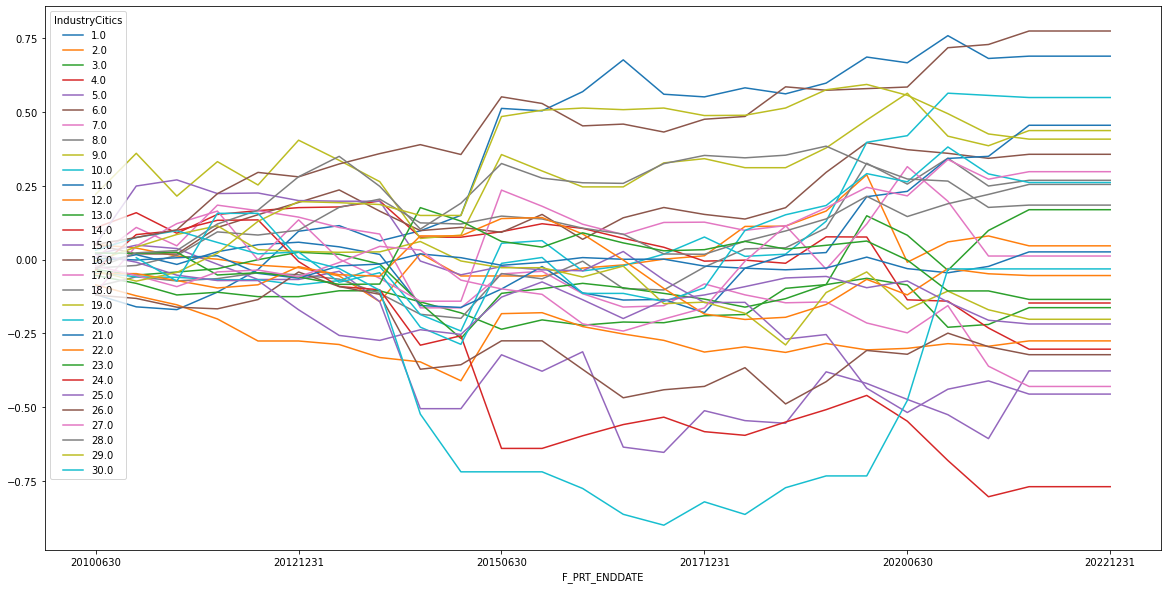

In [204]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [205]:
# df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().pipe(lambda x:np.sqrt(2)*x.mean()/x.std()).sort_values()

In [206]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
24.0   -0.292604
14.0   -0.066949
15.0   -0.038007
7.0    -0.037411
5.0    -0.034319
16.0   -0.028049
4.0    -0.026423
12.0   -0.023984
25.0   -0.018998
19.0   -0.017612
3.0    -0.014833
23.0   -0.011757
22.0   -0.004939
30.0   -0.003749
17.0    0.001075
21.0    0.002152
2.0     0.004213
13.0    0.014068
28.0    0.015369
18.0    0.021212
8.0     0.022375
20.0    0.022698
27.0    0.024806
6.0     0.029716
29.0    0.035477
11.0    0.037916
9.0     0.039725
10.0    0.047741
1.0     0.057434
26.0    0.064539
dtype: float64

In [207]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack()

IndustryCitics,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
F_PRT_ENDDATE,,,,,,,,,,,,,,,,,,,,,
20100630,-0.118685,0.051106,-0.053857,0.107669,0.017701,0.050632,0.005645,-0.091713,0.220912,-0.043355,...,0.004267,-0.047804,0.022146,NaN,0.017591,0.051366,-0.021311,-0.028979,-0.037963,NaN
20101231,-0.041723,-0.012343,-0.027013,0.050928,0.030988,-0.031507,0.103107,0.033035,0.139058,-0.015295,...,-0.005873,NaN,-0.001540,NaN,-0.026709,0.023194,-0.032904,0.051554,-0.035374,0.006123
20110630,-0.009417,-0.026914,-0.039268,-0.069579,-0.011545,-0.000682,-0.062182,-0.013915,-0.145072,-0.001709,...,0.007578,-0.023421,0.004090,NaN,-0.043883,0.026265,-0.037739,0.007760,0.029627,-0.079482
20111231,0.059289,-0.010691,0.009240,0.063800,-0.053216,0.090133,0.137735,0.007848,0.116781,-0.008108,...,0.006912,-0.025284,-0.077114,NaN,-0.018292,0.122350,0.049987,0.089987,0.065089,0.229873
20120630,0.076475,-0.020305,-0.014923,0.012748,-0.051598,0.043288,-0.018820,0.019796,-0.079053,NaN,...,-0.059776,0.010883,0.007837,NaN,NaN,0.072066,0.006179,0.047080,0.108112,NaN
20121231,0.129860,-0.008500,NaN,0.010318,NaN,0.041567,-0.021832,-0.006777,0.151809,-0.017325,...,-0.016340,0.061360,-0.014541,NaN,-0.099020,-0.015092,-0.022601,0.113244,0.066832,-0.152041
20130630,0.019023,-0.027984,0.019894,0.002251,0.027815,0.042430,-0.035088,-0.014854,-0.068241,0.014312,...,0.041644,-0.027213,-0.025219,NaN,-0.086955,0.043654,0.048301,0.068988,-0.003699,-0.035043
20131231,-0.051918,-0.087342,NaN,0.020230,-0.102854,-0.071997,-0.022237,-0.048279,-0.072341,0.047697,...,0.006105,-0.005128,0.001119,NaN,-0.016821,0.035129,0.054660,-0.101649,-0.006151,-0.073911
20140630,0.034339,0.162925,-0.037765,-0.122703,-0.362831,-0.065888,-0.250095,-0.070794,-0.192414,-0.162703,...,0.034510,0.136644,0.259103,NaN,0.036078,0.030349,-0.012339,-0.144956,-0.037121,-0.419401


In [208]:
100*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack()[26]

F_PRT_ENDDATE
20100630     5.136581
20101231     2.319368
20110630     2.626475
20111231    12.234977
20120630     7.206603
20121231    -1.509209
20130630     4.365432
20131231     3.512864
20140630     3.034895
20141231    -3.334371
20150630    19.541522
20151231    -2.253364
20160630    -7.590262
20161231     0.604247
20170630    -2.688938
20171231     4.335353
20180630     0.942599
20181231    10.042115
20190630    -1.162583
20191231     0.557543
20200630     0.539100
20201231    13.320443
20210630     1.094097
20211231     4.571335
20220630          NaN
20221231          NaN
Name: 26.0, dtype: float64

In [209]:
(df_portf[df_portf.IndustryCitics==26]).groupby(['F_PRT_ENDDATE']).STOCK_CODE.count()

F_PRT_ENDDATE
20100630     29
20101231     29
20110630     21
20111231     17
20120630     26
20121231     23
20130630     43
20131231     25
20140630     40
20141231     32
20150630     18
20151231     41
20160630     27
20161231     29
20170630     78
20171231     70
20180630     81
20181231     56
20190630     72
20191231    115
20200630    101
20201231    166
20210630    165
20211231    164
20220630    203
20221231     41
Name: STOCK_CODE, dtype: int64

In [210]:
100*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack()[1]

F_PRT_ENDDATE
20100630   -11.868498
20101231    -4.172288
20110630    -0.941744
20111231     5.928934
20120630     7.647526
20121231    12.985976
20130630     1.902340
20131231    -5.191846
20140630     3.433931
20141231     5.251416
20150630    36.237177
20151231    -0.828391
20160630     6.505590
20161231    10.776074
20170630   -11.650851
20171231    -0.896391
20180630     3.068723
20181231    -2.039859
20190630     3.639271
20191231     8.832544
20200630    -1.946709
20201231     9.193300
20210630    -7.725935
20211231     0.781109
20220630          NaN
20221231          NaN
Name: 1.0, dtype: float64

In [212]:
df_descri = zqdatac.PKLsReader('AShareDescription')

In [222]:
df_descri= df_descri.sort_values(['S_INFO_WINDCODE', 'OPDATE'])

In [226]:
df_descri = df_descri.drop_duplicates(subset=['S_INFO_WINDCODE'],keep='last')

In [231]:
df_portf = df_portf.merge((df_descri[['S_INFO_WINDCODE','S_INFO_LISTDATE']]).rename(columns={'S_INFO_WINDCODE':'STOCK_CODE'}),how='left',on=['STOCK_CODE'])

In [242]:
df_portf[(pd.to_datetime(df_portf.F_PRT_ENDDATE)-pd.to_datetime(df_portf.S_INFO_LISTDATE)).dt.days<0]

,F_PRT_ENDDATE,IndustryCitics,STOCK_CODE,num,total,FUT_RET,IND_FUT_RET,ALPHA,S_INFO_LISTDATE
4913,20220630,10.0,301233.SZ,1,11,NaN,NaN,NaN,20220706
4933,20210630,10.0,688499.SH,1,2,-0.394631,-0.211054,-0.183577,20210701
6515,20220630,12.0,688237.SH,1,25,NaN,NaN,NaN,20220701
11181,20220630,18.0,301239.SZ,1,66,NaN,NaN,NaN,20220705
11289,20210630,18.0,301017.SZ,1,83,0.189491,-0.085586,0.275078,20210705
16310,20211231,26.0,688262.SH,1,37,0.404728,-0.037096,0.441824,20220106
16409,20201231,26.0,003031.SZ,1,100,0.593031,0.199833,0.393198,20210104


#### 热门股

In [147]:
df_portf = portf[portf.total>1]

In [148]:
df_portf = df_portf.reset_index()

In [149]:
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

In [150]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
format_dict = {'ALPHA1': '{:.2%}','ALPHA2': '{:.2%}','ALPHA3': '{:.2%}','ALPHA4': '{:.2%}','ALPHA5': '{:.2%}'}

In [151]:
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,1.07%,-0.27%,0.79%,4.87%,2.15%
2.0,2.98%,-1.40%,-2.09%,-3.49%,-1.23%
3.0,1.25%,-0.28%,-1.20%,0.97%,-0.38%
4.0,0.03%,-0.18%,-2.34%,-3.05%,-0.10%
5.0,1.09%,1.52%,-2.21%,5.92%,1.81%
6.0,-0.61%,0.87%,-2.99%,1.87%,-0.78%
7.0,0.63%,1.37%,-3.67%,-4.58%,0.71%
8.0,0.22%,0.67%,-0.40%,3.73%,-1.29%
9.0,-2.10%,-0.71%,-2.63%,-1.10%,2.54%


In [152]:
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,-1.63%,-0.23%,-0.41%,3.32%,-0.90%
2.0,1.64%,0.38%,-1.29%,-1.07%,1.46%
3.0,-0.12%,-3.47%,0.07%,0.85%,-0.16%
4.0,-0.72%,-2.71%,-2.01%,0.60%,0.00%
5.0,3.58%,-2.51%,-2.28%,-3.11%,-0.36%
6.0,0.49%,-0.25%,1.01%,1.99%,0.02%
7.0,-0.02%,3.47%,-3.13%,2.59%,1.03%
8.0,2.72%,-1.28%,-0.02%,2.99%,-0.32%
9.0,-0.54%,3.47%,1.06%,-1.57%,3.04%


In [153]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])

In [154]:
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])

In [155]:
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
# df_portf['ALPHA'] = (df_portf.FUT_RET3 + 1)*(df_portf.FUT_RET4 + 1)*(df_portf.FUT_RET5 + 1) - (df_portf.IND_FUT_RET3 + 1)*(df_portf.IND_FUT_RET4 + 1)*(df_portf.IND_FUT_RET5 + 1)

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

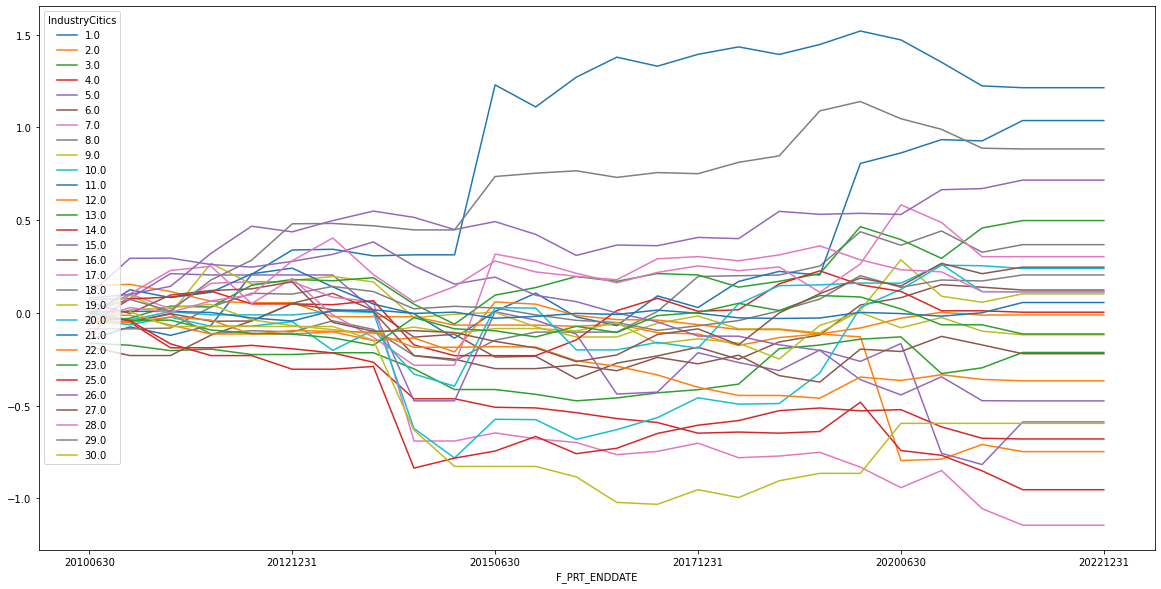

In [156]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [157]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
7.0    -0.104027
30.0   -0.091593
4.0    -0.086647
2.0    -0.074769
25.0   -0.061769
5.0    -0.058773
15.0   -0.039529
22.0   -0.034872
3.0    -0.020313
16.0   -0.019996
19.0   -0.010251
23.0   -0.009865
12.0   -0.001093
14.0    0.000373
21.0    0.004669
9.0     0.009345
28.0    0.009460
20.0    0.009900
6.0     0.010282
18.0    0.017801
27.0    0.020546
10.0    0.020819
17.0    0.027554
8.0     0.033441
13.0    0.041483
26.0    0.059662
29.0    0.076843
11.0    0.086403
1.0     0.105550
dtype: float64

In [158]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack()

IndustryCitics,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,20.0,21.0,22.0,23.0,25.0,26.0,27.0,28.0,29.0,30.0
F_PRT_ENDDATE,,,,,,,,,,,,,,,,,,,,,
20100630,-0.144108,0.146681,-0.163383,-0.047591,0.072857,-0.181925,-0.003520,NaN,-0.005799,0.004469,...,-0.042957,0.004267,-0.051960,-0.000125,-0.020497,0.080077,0.055559,-0.042619,0.006904,NaN
20101231,0.068448,0.007198,-0.010842,-0.002850,0.004691,-0.047873,0.105332,-0.048990,0.101014,-0.042229,...,-0.020597,0.003875,NaN,-0.040259,-0.021212,0.019869,-0.058341,0.071087,0.065457,0.006123
20110630,-0.045345,-0.038906,-0.029063,-0.137606,0.134260,0.000006,-0.079924,0.042604,-0.099754,0.044777,...,0.040275,0.000222,0.030050,0.001336,-0.125016,0.043274,0.098994,-0.025739,-0.062060,-0.079482
20111231,0.054415,-0.052170,0.008053,NaN,-0.007368,0.110179,0.137779,-0.106134,0.272098,-0.017542,...,-0.049124,-0.006228,-0.016724,-0.053134,-0.063340,0.178114,0.024475,0.062125,0.167389,NaN
20120630,0.273919,-0.008352,-0.029075,0.013096,NaN,0.076583,0.008220,0.016447,-0.112957,NaN,...,0.001426,-0.029128,-0.076748,-0.017844,NaN,0.145904,0.009061,0.033344,0.106257,NaN
20121231,0.131659,0.000531,NaN,-0.018376,NaN,0.094591,NaN,-0.006344,0.020744,-0.000692,...,0.023844,-0.016750,0.020531,-0.004285,-0.073556,-0.030323,0.037413,0.182726,0.196308,NaN
20130630,0.003989,-0.075432,0.009583,-0.022458,NaN,0.053974,-0.083358,0.059877,0.021099,0.020849,...,-0.155063,0.056113,-0.004621,-0.020249,NaN,0.060607,-0.218553,0.122847,0.001900,NaN
20131231,-0.035307,NaN,NaN,-0.050387,-0.188657,-0.090669,-0.025024,-0.046472,-0.029745,-0.006526,...,0.110617,0.004220,-0.004453,-0.039628,0.015184,0.051274,-0.047466,-0.197227,-0.012748,-0.073911
20140630,0.005297,NaN,-0.086733,-0.196889,-0.489859,-0.145361,-0.750140,-0.141352,-0.192414,-0.625983,...,-0.238214,-0.019411,-0.081363,0.148861,-0.548232,-0.033754,0.003007,-0.147242,-0.021966,-0.484551


In [159]:
(df_portf[(df_portf.IndustryCitics==26)&(df_portf.F_PRT_ENDDATE=='20201231')]).sort_values(by=['total','ALPHA']).head(20)

,F_PRT_ENDDATE,IndustryCitics,STOCK_CODE,num,total,FUT_RET,IND_FUT_RET,ALPHA
9490,20201231,26.0,002992.SZ,1,2,-0.294600,0.199833,-0.494433
10455,20201231,26.0,002463.SZ,1,2,-0.254855,0.199833,-0.454689
9477,20201231,26.0,002981.SZ,1,2,-0.204815,0.199833,-0.404648
9470,20201231,26.0,000021.SZ,1,2,-0.158724,0.199833,-0.358557
9474,20201231,26.0,002861.SZ,1,2,-0.132935,0.199833,-0.332769
9488,20201231,26.0,300857.SZ,1,2,-0.023121,0.199833,-0.222955
9479,20201231,26.0,605118.SH,1,2,-0.020667,0.199833,-0.220500
9492,20201231,26.0,000050.SZ,1,2,0.015526,0.199833,-0.184307
9421,20201231,26.0,300566.SZ,1,2,0.016421,0.199833,-0.183412
9476,20201231,26.0,002983.SZ,1,2,0.080741,0.199833,-0.119093


In [160]:
(df_portf[(df_portf.IndustryCitics==26)&(df_portf.F_PRT_ENDDATE=='20201231')]).sort_values(by=['total','ALPHA']).tail(20)

,F_PRT_ENDDATE,IndustryCitics,STOCK_CODE,num,total,FUT_RET,IND_FUT_RET,ALPHA
10240,20201231,26.0,300661.SZ,1,31,1.078661,0.199833,0.878828
10453,20201231,26.0,300408.SZ,1,33,-0.096222,0.199833,-0.296056
10462,20201231,26.0,002415.SZ,1,33,-0.068932,0.199833,-0.268765
10391,20201231,26.0,688012.SH,1,33,0.533346,0.199833,0.333512
9871,20201231,26.0,688536.SH,1,35,0.633038,0.199833,0.433204
10041,20201231,26.0,300884.SZ,1,37,-0.131074,0.199833,-0.330908
10389,20201231,26.0,603501.SH,1,38,-0.056021,0.199833,-0.255854
10278,20201231,26.0,000725.SZ,1,39,-0.056554,0.199833,-0.256388
10321,20201231,26.0,603986.SH,1,39,0.257945,0.199833,0.058112
10315,20201231,26.0,002049.SZ,1,39,1.092970,0.199833,0.893136


#### 冷门股

In [161]:
df_portf = portf[portf.total<=1]

In [162]:
df_portf = df_portf.reset_index()

In [163]:
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

In [164]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
format_dict = {'ALPHA1': '{:.2%}','ALPHA2': '{:.2%}','ALPHA3': '{:.2%}','ALPHA4': '{:.2%}','ALPHA5': '{:.2%}'}

In [165]:
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,2.16%,2.56%,0.44%,0.09%,4.68%
2.0,-0.51%,-0.31%,0.87%,2.81%,4.46%
3.0,-0.21%,0.55%,-0.31%,0.35%,-0.57%
4.0,-0.26%,0.24%,1.00%,0.30%,0.29%
5.0,0.42%,2.47%,-1.21%,0.58%,-2.66%
6.0,0.31%,-0.39%,2.14%,2.63%,-1.27%
7.0,-1.05%,4.36%,-0.76%,-1.06%,2.21%
8.0,1.94%,-0.54%,0.87%,0.61%,-0.42%
9.0,-0.13%,4.85%,-1.37%,-1.13%,3.57%


In [166]:
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,4.35%,0.62%,-0.86%,11.06%,-0.38%
2.0,-0.21%,2.41%,1.78%,-1.08%,0.67%
3.0,-2.01%,1.50%,-0.50%,3.35%,0.42%
4.0,-0.18%,0.99%,1.65%,0.78%,0.80%
5.0,-1.53%,-4.58%,-1.49%,6.88%,0.36%
6.0,0.15%,1.39%,-1.24%,1.61%,-0.75%
7.0,0.20%,-1.26%,-1.57%,6.59%,-1.69%
8.0,0.57%,3.26%,0.07%,0.44%,2.28%
9.0,-0.07%,0.97%,-0.86%,2.49%,2.69%


In [167]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])

In [168]:
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])

In [169]:
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

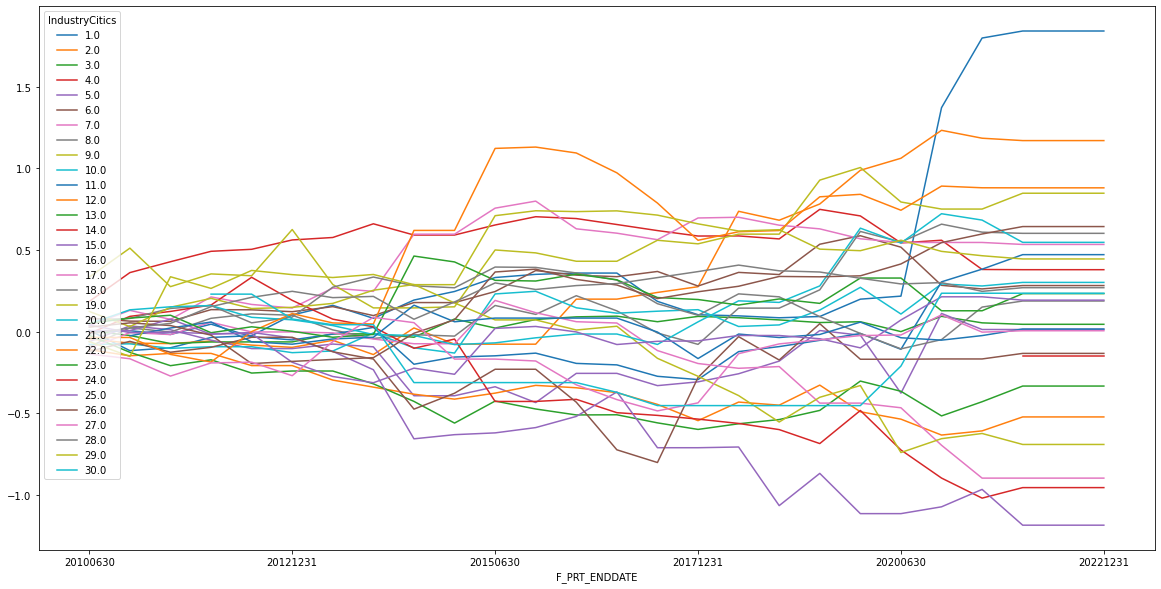

In [170]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [171]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
24.0   -0.292604
15.0   -0.112780
17.0   -0.089615
14.0   -0.082976
19.0   -0.060013
12.0   -0.047422
13.0   -0.028931
16.0   -0.013282
27.0    0.000484
5.0     0.001343
21.0    0.001657
3.0     0.004112
18.0    0.015650
25.0    0.017551
23.0    0.021182
28.0    0.022445
6.0     0.023536
10.0    0.026229
4.0     0.032998
29.0    0.038714
11.0    0.039294
20.0    0.047547
7.0     0.050854
8.0     0.052345
26.0    0.053618
30.0    0.058854
22.0    0.080043
9.0     0.084744
2.0     0.111390
1.0     0.160025
dtype: float64

In [172]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack()

IndustryCitics,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
F_PRT_ENDDATE,,,,,,,,,,,,,,,,,,,,,
20100630,0.008429,-0.044468,0.005885,0.185299,-0.061093,0.083854,0.037721,-0.091713,0.334268,-0.077514,...,NaN,-0.035338,0.051269,NaN,0.040444,0.028038,-0.136617,-0.014201,-0.060397,NaN
20101231,-0.124351,-0.025371,-0.029034,0.176408,0.096731,-0.019233,0.092723,0.115061,0.177103,0.003133,...,-0.025368,NaN,0.031647,NaN,-0.045951,0.025895,-0.028990,0.036904,-0.091392,NaN
20110630,0.017528,-0.002929,-0.049472,0.066473,-0.023696,-0.001127,-0.055085,-0.025219,-0.235706,-0.027534,...,0.048037,-0.103628,0.017860,NaN,0.002478,-0.016258,-0.106105,0.028233,0.488060,NaN
20111231,0.063188,0.015705,0.009671,0.063800,-0.063797,0.071519,0.137336,0.083836,0.077951,0.009903,...,0.036477,-0.046682,-0.107089,NaN,-0.008809,-0.058883,0.080600,0.102524,-0.071310,0.229873
20120630,0.010661,-0.025086,0.000407,0.012254,-0.051598,-0.001106,-0.045861,0.027166,-0.011244,NaN,...,-0.121073,0.186144,0.036371,NaN,NaN,-0.174060,0.004450,0.056892,0.109967,NaN
20121231,0.126860,-0.013661,NaN,0.057271,NaN,-0.011457,-0.021832,-0.008509,0.282875,-0.036335,...,-0.014495,0.110355,-0.027728,NaN,-0.175414,0.013465,-0.082614,0.036815,-0.025651,-0.152041
20130630,0.059114,0.043189,0.049354,0.015064,0.027815,0.030885,0.121789,-0.089584,-0.336261,0.010110,...,0.031998,-0.057335,-0.036401,NaN,-0.086955,0.012008,0.208413,-0.038732,-0.017697,-0.035043
20131231,-0.079605,-0.087342,NaN,0.083784,-0.017051,-0.054761,-0.020006,-0.052495,-0.143335,0.110958,...,0.010346,-0.006254,0.017417,NaN,-0.038157,0.010910,0.148931,0.007584,0.018585,NaN
20140630,0.111786,0.162925,-0.020626,-0.068750,-0.299317,0.079811,0.349960,0.023282,NaN,-0.091429,...,0.196273,0.572659,0.479588,NaN,0.089197,0.149397,-0.032802,-0.139846,-0.062378,-0.354250
